In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.optimize as opt
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
path = 'D:/Google_Download/andrew_ml_ex55139/ex5data1.mat'
data = sio.loadmat(path)
data['X'].shape,data['y'].shape,data['Xtest'].shape,data['ytest'].shape,data['Xval'].shape,data['yval'].shape
X,y,Xtest,ytest,Xval,yval = map(np.ravel,[data['X'],data['y'],data['Xtest'],data['ytest'],data['Xval'],data['yval']])
X.shape,y.shape,Xtest.shape,ytest.shape,Xval.shape,yval.shape

((12,), (12,), (21,), (21,), (21,), (21,))

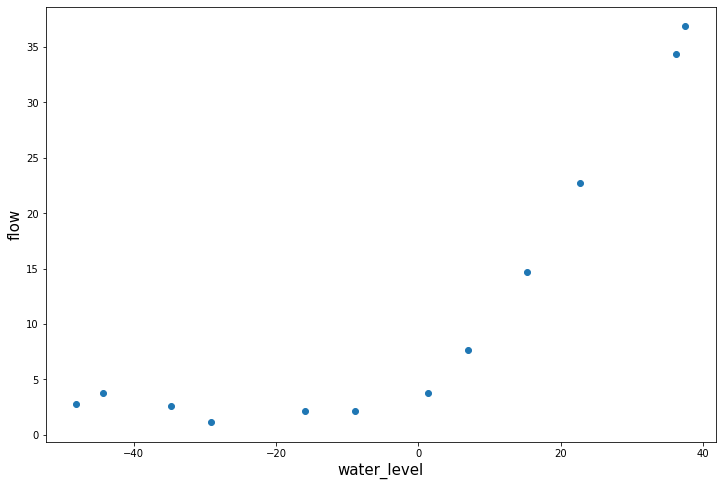

In [3]:
# 描绘出X,y对应的点
plt.figure(figsize=(12,8))
plt.scatter(X,y)
plt.xlabel('water_level',size=15)
plt.ylabel('flow',size=15)
plt.show()

In [4]:
# 完善数据，将x前面增加一个0
X,Xtest,Xval = [np.insert(x.reshape((len(x),1)),0,values=np.ones(len(x)),axis=1) for x in (X,Xtest,Xval)]
X.shape,Xtest.shape,Xval.shape

((12, 2), (21, 2), (21, 2))

In [5]:
# 定义代价函数
def cost(theta,X,y):
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(theta)
    
    
    m = X.shape[0]
    error = X*theta.T-y
    return np.sum(np.power(error,2))/(2*m)

In [6]:
def costReg(theta,X,y,reg=1):
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(theta)
    m = X.shape[0]
    
    return cost(theta,X,y)+float(reg/(2*m))*np.sum(np.power(theta[:,1:],2))

In [7]:
y,yval,ytest = [np.reshape(y_i,(len(y_i),1)) for y_i in (y,yval,ytest)] 
theta = np.ones(X.shape[1])
costReg(theta, X, y, 1)

303.9931922202643

In [8]:
# 正则化线性回归梯度
def gradient(theta,X,y):
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(theta)
    m = X.shape[0]
    
    grad = np.zeros(theta.shape)
    error = X*theta.T-y
    grad = X.T*error
    grad/=m
    return np.array(grad).flatten()

In [9]:
# 正则化梯度下降
def gradientReg(theta,X,y,reg=1):
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(theta)
    m = X.shape[0]
    
    grad = gradient(theta,X,y)
    grad[1:] += float(reg/m)*np.array(theta[:,1:]).flatten()
    return grad

In [10]:
gradientReg(theta,X,y,reg=1)

array([-15.30301567, 598.25074417])

In [11]:
# 拟合线性回归
final_theta = opt.minimize(fun=costReg,x0=theta,args=(X,y,0),method='TNC',jac=gradientReg,options={'disp':True}).x
final_theta

array([13.08790348,  0.36777923])

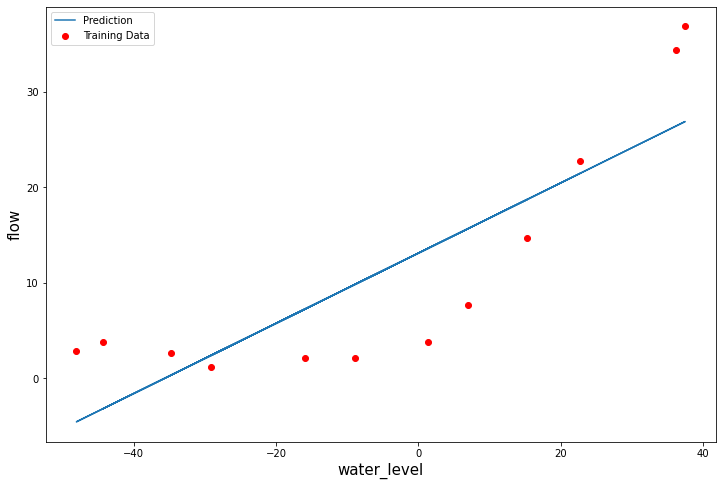

In [12]:
# 对数据拟合一条直线
b = final_theta[0]
w = final_theta[1]

plt.figure(figsize=(12,8))
plt.scatter(X[:,1],y,color='r',label='Training Data')
plt.plot(X[:,1],w*X[:,1]+b,label='Prediction')
plt.xlabel('water_level',size=15)
plt.ylabel('flow',size=15)
plt.legend(loc='best')
plt.show()

In [13]:
# 定义一个函数，让其返回拟合后的theta值，其实就是minimize的功能
def linear_regression(X,y,l):
    init_theta = np.zeros(X.shape[1])
    return opt.minimize(fun=costReg,x0=init_theta,args=(X,y,l),method='TNC',jac=gradientReg,options={'disp':True})

In [14]:
# 根据不同的训练集大小，计算出相应的代价值，一个是J(train)一个是J(cross validation)
# 该出的代价函数不能使用含有reg的，因为reg的作用仅仅是选择更好的theta，而评价该参数时不应使用
training_cost,val_cost = [],[]
m = X.shape[0]
for i in range(1,m+1):
    opt_theta = linear_regression(X[:i,:],y[:i,:],0)
    # 利用这个opt_theta求解J(train)和J(cross validation)
    training_cost += [cost(opt_theta.x,X[:i,:],y[:i,:])]
    val_cost += [cost(opt_theta.x,Xval,yval)]
    pass
training_cost,val_cost

([1.0176953929799205e-18,
  3.4671308818173964e-09,
  3.2865950455012913,
  2.8426776893999373,
  13.154048809114926,
  19.443962512495464,
  20.098521655088888,
  18.17285869520002,
  22.60940542495473,
  23.261461592611816,
  24.31724958804416,
  22.373906495108912],
 [205.1210957127572,
  110.30264077542824,
  45.0102314530931,
  48.36891025069481,
  35.865164739151226,
  33.82996154859687,
  31.970985830253063,
  30.86244631444088,
  31.13599786459523,
  28.93620747034826,
  29.55143161970526,
  29.433818127872954])

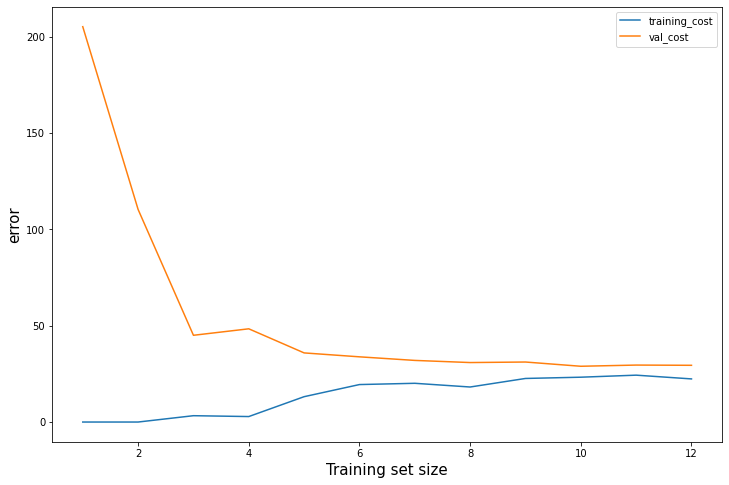

In [15]:
# 根据以上点绘制学习曲线
ax = plt.subplots(figsize=(12,8))
plt.plot(range(1,m+1),training_cost,label='training_cost')
plt.plot(range(1,m+1),val_cost,label='val_cost')
plt.legend(loc='best')
plt.xlabel('Training set size',size=15)
plt.ylabel('error',size=15)
plt.show()

In [16]:
# 由此可知，此图产生了欠拟合，因此要解决这个欠拟合
# 可以有以下方法：
# 1.增加feature，或者提高特征幂次
# 2.增加样本是没有效果滴
# 3.减小λ的值，但是我们这里还没有使用λ，因此这里只能使用提高幂次的方式

# 定义一个函数能产生多项式的矩阵
def poly_features(x,power,as_ndarray):
    data = {'f{}'.format(i):np.power(x,i) for i in range(1,power+1)}
    df = pd.DataFrame(data)
    return df.value if as_ndarray else df

In [17]:
data = sio.loadmat(path)
X,y,Xtest,ytest,Xval,yval = map(np.ravel,[data['X'],data['y'],data['Xtest'],data['ytest'],data['Xval'],data['yval']])
# 将y进行矩阵化
y,yval,ytest = [np.reshape(y_i,(len(y_i),1)) for y_i in (y,yval,ytest)] 
# X = poly_features(X,8,as_ndarray=False)
# X

In [18]:
# 归一化的函数
def normalize_feature(df):
    return df.apply(lambda column:(column-column.mean())/column.std())

In [19]:
def prepare_poly_data(*args,power):
    # 在函数内部定义另一个函数
    def prepare(x):
        df = poly_features(x,power,as_ndarray=False)
        ndarr = normalize_feature(df).values
        # 第一列增加一个1
        return np.insert(ndarr,0,values=np.ones(ndarr.shape[0]),axis=1)
    
    return [prepare(x) for x in args]

In [20]:
X_poly,Xval_poly,Xtest_poly = prepare_poly_data(X,Xval,Xtest,power=8)
X_poly[:3,:]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

In [21]:
# 画出学习曲线，我们没有使用λ，其值为0
def plot_learning_curve(X,Xinit,y,Xval,yval,l=0):
    training_cost,cv_cost = [],[]
    m = X.shape[0]
    for i in range(1,m+1):
        res = linear_regression(X[:i,:],y[:i,:],l)
        training_cost += [cost(res.x,X[:i,:],y[:i,:])]
        cv_cost += [cost(res.x,Xval,yval)]
        pass
    # 绘制图像
    fig,ax = plt.subplots(2,1,figsize=(12,12))
    ax[0].plot(np.arange(1,m+1),training_cost,label='training_cost')
    ax[0].plot(np.arange(1,m+1),cv_cost,label='cv_cost')
    ax[0].legend(loc='best')
    ax[0].set_xlabel('Training set size',size=15)
    ax[0].set_ylabel('error',size=15)
    
    # 绘制散点图
    ax[1].scatter(Xinit,y)
    _xinit = np.linspace(np.min(Xinit),np.max(Xinit),100)
    _x = prepare_poly_data(_xinit,power=8)
    _y = np.dot(_x[0], linear_regression(X, y, l).x.T)
    
    ax[1].plot(_xinit,_y)
    ax[1].set_xlabel('water_level',size=15)
    ax[1].set_ylabel('flow',size=15)

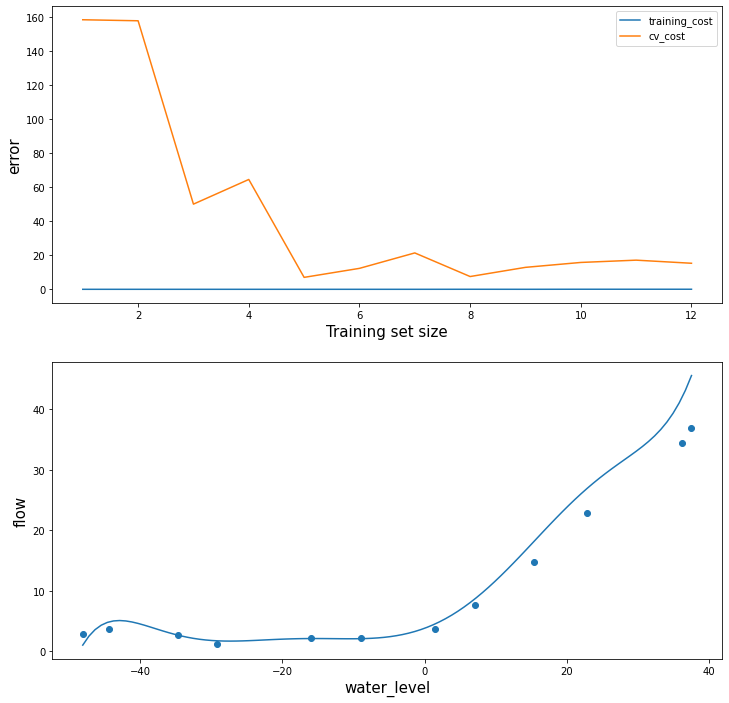

In [22]:
# plot_learning_curve(X_poly, X, y, Xval_poly, yval, l=0)
# plt.show()
plot_learning_curve(X_poly, X, y, Xval_poly, yval, l=0)
plt.show()

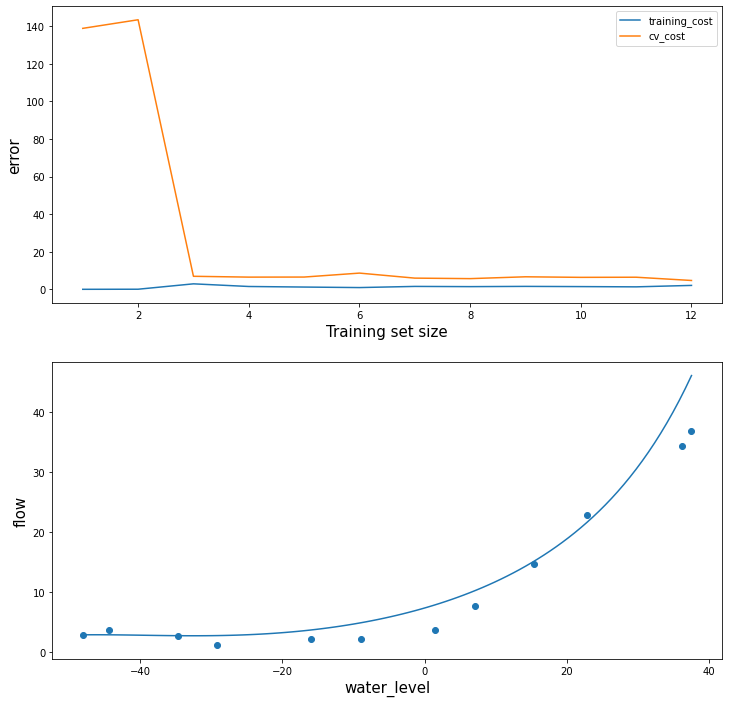

In [23]:
# 根据图像判断此时过拟合，然后可以使用lambda参数处理过拟合
# 求最佳的λ处理过拟合
# 可以看到cv_cost也降低后趋于平稳
plot_learning_curve(X_poly, X, y, Xval_poly, yval, l=1)
plt.show()

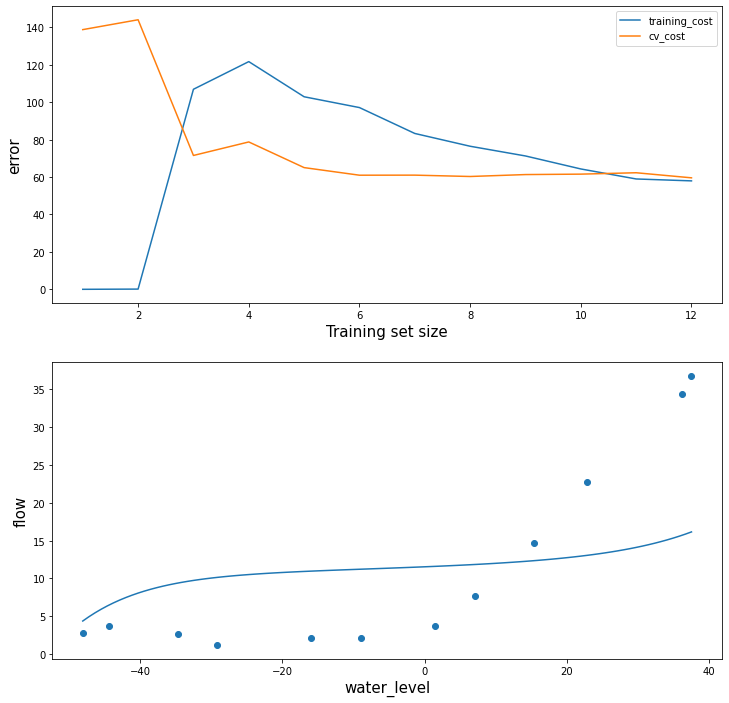

In [24]:
# 此时发现J(Train)也变大很多，说明又出现了欠拟合，从图像也可以看出来没有很好的拟合这些点
plot_learning_curve(X_poly, X, y, Xval_poly, yval, l=100)
plt.show()

In [25]:
# 什么时候最合适呢？我们通过多组λ进行绘制曲线
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost,cv_cost = [],[]

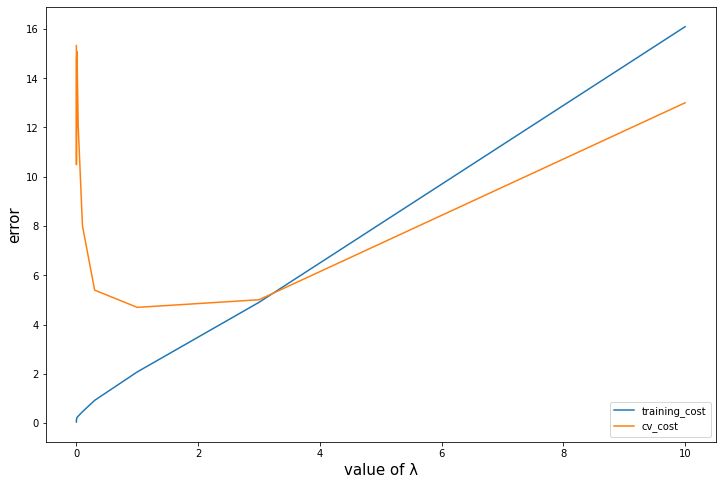

In [26]:
for i in l_candidate:
    res = linear_regression(X_poly,y,i)
    training_cost += [cost(res.x,X_poly,y)]
    cv_cost += [cost(res.x,Xval_poly,yval)]
    pass
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(l_candidate,training_cost,label='training_cost')
ax.plot(l_candidate,cv_cost,label='cv_cost')
ax.set_xlabel('value of λ',size=15)
ax.set_ylabel('error',size=15)
ax.legend()
plt.show()

In [29]:
# 可以看出当λ取值为1是cv_cost具有最小值，此时我们选择的模型最好
# 下面在测试集上测试该模型的性能
theta = linear_regression(X_poly,y,l=1)
theta
print('Test cost:{}'.format(cost(theta.x,Xtest_poly,ytest)))

Test cost:7.4663042454349515
